In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataloader
import torchvision
from torchvision import transforms 

# 1. Загрузка данных

In [2]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

size_crop = 224
train_transform = transforms.Compose([
    transforms.RandomCrop(size_crop),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-20, 20]),
    transforms.ToTensor(),
    normalize,
])
val_transform = transforms.Compose([
    transforms.RandomCrop(size_crop),
    transforms.ToTensor(),
    normalize,
])
test_transform = transforms.Compose([
    transforms.RandomCrop(size_crop),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-20, 20]),
    transforms.ToTensor(),
    normalize,
])

# разбил размеченные 20 картинок на train и val в соотношениее 16/4
train_dataset = torchvision.datasets.ImageFolder('data/train/', transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder('data/val/', transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder('data/test/', transform=test_transform)
all_train_dataset = torchvision.datasets.ImageFolder(
    'superbowllsh/superbowllsh/train/', transform=train_transform)

In [3]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=0,
    shuffle=True
)
all_train_loader = torch.utils.data.DataLoader(
    all_train_dataset,
    batch_size=8,
    num_workers=0,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    num_workers=0,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=4,
    num_workers=0,
    shuffle=False
)

# 2. Создаём модель

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

def get_model(): 
    model = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.BatchNorm2d(16),

        nn.Conv2d(16, 32, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.BatchNorm2d(32),

        nn.Conv2d(32, 64, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 128, 3, padding=1),
        nn.MaxPool2d(4),
        nn.ReLU(),
        Flatten(),

        nn.Linear(7 * 7 * 128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )
    return model

def get_loss(logit, y):
    loss = F.nll_loss(F.log_softmax(logit, dim=1), y)
    return loss

# 3. Обучаем

#### обучаем на 16 картинках из train, валидируемся на 4 оставшихся в train

In [5]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

hist_train_loss = []
hist_val_loss = []

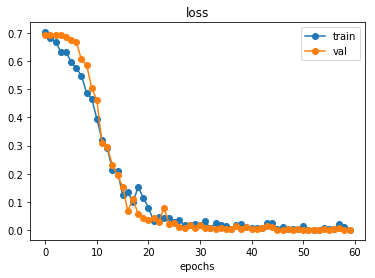

In [6]:
epochs = 60
for epoch in range(epochs):
    model.train()
    losses = []
    for data, target in train_loader:
        optim.zero_grad()
        output = model(data)
        loss = get_loss(output, target)
        losses.append(loss.data.numpy())
        loss.backward()
        optim.step()
    hist_train_loss.append(np.mean(losses))
    
    model.eval()
    losses = []
    for data, target in val_loader:
        output = model(data)
        loss = get_loss(output, target)
        losses.append(loss.data.numpy())
    hist_val_loss.append(np.mean(losses))
    
    plt.plot(np.arange(len(hist_train_loss)), hist_train_loss, '-o', label='train')
    plt.plot(np.arange(len(hist_val_loss)), hist_val_loss, '-o', label='val')
    plt.legend()
    plt.title('loss')
    plt.xlabel('epochs')
    plt.show()
    clear_output(wait=True)

#### обучаем на всех 20 картинках из train

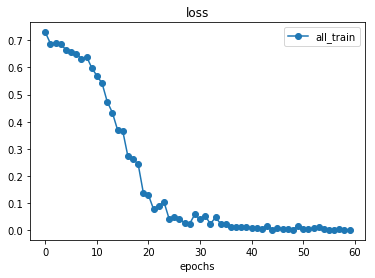

In [7]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

hist_train_loss = []
hist_val_loss = []


epochs = 60
for epoch in range(epochs):
    model.train()
    
    losses = []
    for data, target in all_train_loader:
        optim.zero_grad()
        output = model(data)
        loss = get_loss(output, target)
        losses.append(loss.data.numpy())
        loss.backward()
        optim.step()
    hist_train_loss.append(np.mean(losses))
    
    plt.plot(np.arange(len(hist_train_loss)), hist_train_loss, '-o', label='all_train')
    plt.legend()
    plt.title('loss')
    plt.xlabel('epochs')
    plt.show()
    clear_output(wait=True)

# 4. Итоговое предсказание и сохранение результата

Делаем предсказания для различных трансформаций тестовых картинок и усредняем результат.

In [8]:
test_names = [path.split('/')[-1][:-4] for path, _ in test_dataset.imgs]
res_df = pd.DataFrame({'id': test_names})

model.eval()
for i in range(15):
    res = []
    for data, target in test_loader:
        output = model(data)
        res.append(output.argmax(dim=1).numpy())
    res_df[f'res_{i}'] = np.hstack(res)

res_df['mean'] = res_df.drop('id', axis=1).mean(axis=1)
res_df['label'] = ['dirty' if x >= 0.5 else 'cleaned' for x in res_df['mean']]
res_df[['id', 'label']].to_csv('answer.csv', index=False)

In [9]:
res_df.head()

,id,res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9,res_10,res_11,res_12,res_13,res_14,mean,label
0,0000,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0.866667,dirty
1,0001,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,dirty
2,0002,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,dirty
3,0003,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0.866667,dirty
4,0004,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,dirty
